In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random

In [2]:
def compute_chi(data):
    '''
    Computes the value of Chi, a synchrony measurement that compares the variance of individual voltage traces and the variance of the mean of the voltages.

    Parameters:
        data (list[float]):
            Voltage traces with each row corresponding one neuron.

    Returns:
        chi (float):
            The value of Chi.
    '''

    #calculate the average voltage as a function of time
    mean_voltage = np.mean(data,axis=0)

    #calculate the variance of each trave and the average voltage
    ind_variance = np.mean(np.square(data),axis=1) - np.mean(data,axis=1)**2
    total_variance = np.mean(np.square(mean_voltage)) - np.mean(mean_voltage)**2

    #calculate chi
    chi = np.sqrt(total_variance**2 / np.mean(ind_variance**2))

    return chi 


findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


Average number of connections per neuron: 39.56
Connectivity Matrix g [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.33022684 ... 0.         0.41722493 0.        ]
 [0.         0.3561603  0.         ... 0.         0.         0.        ]
 ...
 [0.31972699 0.         0.         ... 0.         0.         0.        ]
 [0.         0.43372646 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Average value of matrix g= 0.049546704329874756


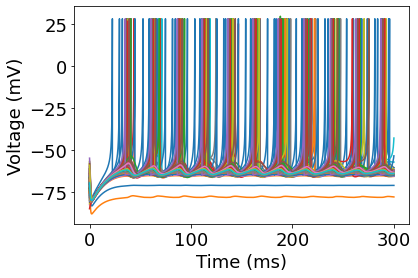

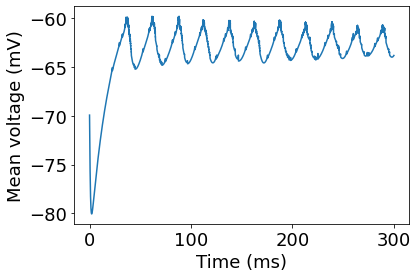

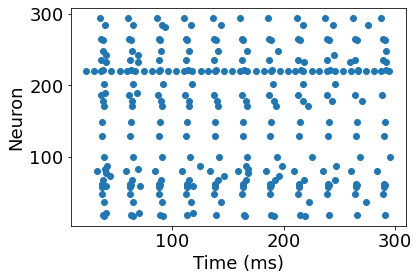

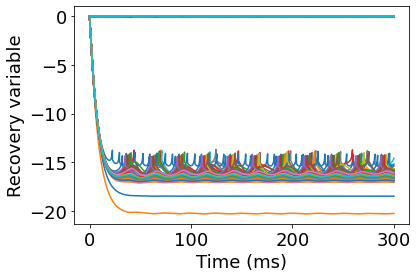

In [3]:
# Making neuron sparsely connected for second order synaptic term
# Has identical code to paper except different synaptic term (2nd order given by Aine)
# Changed the synaptic coupling to be probabilistic
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random

np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043

J = np.random.normal(0, 0.25, size=(N))

I0 = 0.15
delta = 0.02  
I = stats.cauchy.rvs(loc=I0, scale=delta, size=(N))

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = np.random.uniform(0.25, 0.5)  # Set random connection strength 

# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 5, size=(N))
u_init = np.zeros(N)
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init += 1 / (tauS * N)
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter += 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')

spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

plt.figure()
plt.plot(t_all, y_all[N:, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable')



# Count the number of non-zero entries in each row
connections_per_neuron = np.count_nonzero(g, axis=1)

# Calculate the average number of connections per neuron
average_connections = np.mean(connections_per_neuron)

print(f"Average number of connections per neuron: {average_connections}")
print("Connectivity Matrix g", g)
print("Average value of matrix g=", np.mean(g))

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


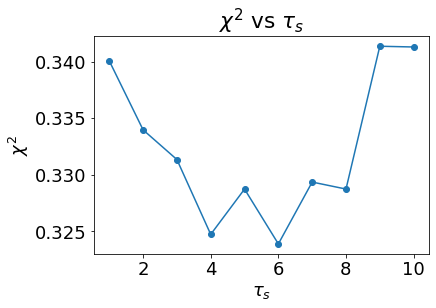

In [4]:
# Define the range of tau_s values
tau_s_values = np.arange(1, 11, 1)  # Values from 0 to 10 inclusive
chi_sq_values = []

# Loop over different values of tau_s
for tau_s in tau_s_values:
    # Reinitialize initial conditions for each tau_s run
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.zeros(N)
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with new tau_s
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current tau_s
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tau_s), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init += 1 / (tau_s * N) if tau_s > 0 else 0  # Avoid division by zero for tau_s=0
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter += 1
            i += 1

    # Compute chi_sq for current tau_s
    data = y_all[:N, :]
    chi_sq = compute_chi(data)
    chi_sq_values.append(chi_sq)

# Plotting the results
plt.figure()
plt.plot(tau_s_values, chi_sq_values, marker='o', linestyle='-')
plt.xlabel(r'$\tau_s$')
plt.ylabel(r'$\chi^2$')
plt.title(r'$\chi^2$ vs $\tau_s$')
plt.show()


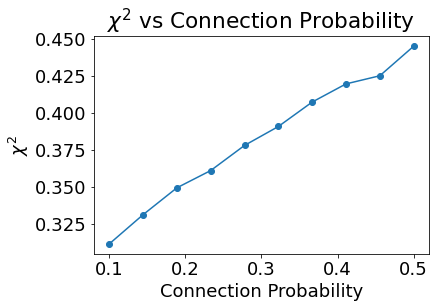

In [5]:
# Define different connectivity parameters for g
connection_probs = np.linspace(0.1, 0.5, 10)  # Vary connection probability from 0.1 to 0.5
chi_sq_values = []

# Loop over different values of connection probability for g
for conn_prob in connection_probs:
    # Initialize synaptic coupling matrix with new connection probability
    g = np.zeros((N, N))
    for j in range(N):
        for i in range(N):
            if i != j:  # Avoid self-connections
                if np.random.rand() < conn_prob:
                    g[j, i] = np.random.uniform(0.25, 0.5)  # Set random connection strength

    # Reinitialize initial conditions for each g matrix run
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.zeros(N)
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with the current synaptic coupling matrix g
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current g matrix
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init += 1 / (tauS * N) if tauS > 0 else 0  # Avoid division by zero if tauS=0
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter += 1
            i += 1

    # Compute chi_sq for the current g matrix
    data = y_all[:N, :]
    chi_sq = compute_chi(data)
    chi_sq_values.append(chi_sq)

# Plotting the results
plt.figure()
plt.plot(connection_probs, chi_sq_values, marker='o', linestyle='-')
plt.xlabel('Connection Probability')
plt.ylabel(r'$\chi^2$')
plt.title(r'$\chi^2$ vs Connection Probability')
plt.show()


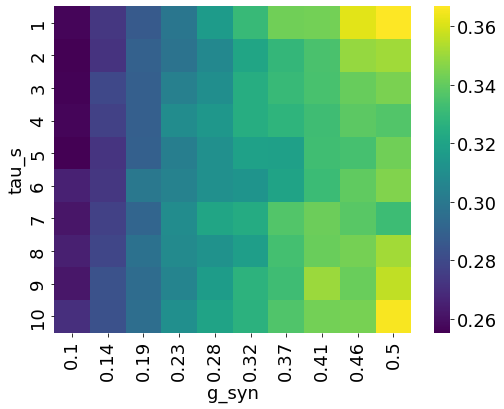

In [6]:
tau_s_values = np.arange(1, 11, 1)  
g_syn_values = np.linspace(0.1, 0.5, 10)  

chi_sq_matrix = np.zeros((len(tau_s_values), len(g_syn_values)))

for i, tau_s in enumerate(tau_s_values):
    for j, g_syn in enumerate(g_syn_values):
        g = np.zeros((N, N))
        for row in range(N):
            for col in range(N):
                if row != col:  
                    if np.random.rand() < connection_probability:
                        g[row, col] = np.random.uniform(g_syn - 0.1, g_syn + 0.1)  

        v_init = np.random.normal(-70, 5, size=(N))
        u_init = np.zeros(N)
        s_init = np.zeros(N)
        p_init = np.zeros(N)
        
        t_all = np.array([t0])
        y_0 = np.concatenate([v_init, u_init, s_init, p_init])
        y_all = np.reshape(y_0, (y_0.shape[0], 1))
        
        spike_times = np.zeros((M, 2))
        spikeCounter = 0
        t0 = 0  
        i_step = 0

        while i_step < M and t0 < T:
            y0 = np.concatenate([v_init, u_init, s_init, p_init])  

            
            sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tau_s), dense_output=True, 
                              events=v_spike, rtol=1e-8)

            t_end = sol_v.t[-1]
            steps = max([2, int((t_end - t0) / dt)])
            t = np.linspace(t0, t_end, steps)
            y = sol_v.sol(t)
            
            t_all = np.concatenate([t_all, t[:-1]], axis=0)
            y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

            t0 = t_end
            v_init = y[:N, -1]
            u_init = y[N:2*N, -1]
            s_init = y[2*N:3*N, -1]
            p_init = y[3*N:4*N, -1]

            if len(sol_v.t_events[0]) > 0:
                spike = v_init.argmax()
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init += 1 / (tau_s * N) if tau_s > 0 else 0
                
                spike_times[spikeCounter, :] = [t0, spike]
                spikeCounter += 1
                i_step += 1

        data = y_all[:N, :]
        chi_sq = compute_chi(data)
        chi_sq_matrix[i, j] = chi_sq

plt.figure(figsize=(8, 6))
sns.heatmap(chi_sq_matrix, xticklabels=np.round(g_syn_values, 2), yticklabels=tau_s_values, cmap='viridis')
plt.xlabel('g_syn')
plt.ylabel('tau_s')
plt.show()


In [7]:
# Initialize a dictionary to store spike times for each neuron
neuron_spike_times = {i: [] for i in range(N)}

# Iterate through the spike_times array
for time, neuron in spike_times:
    if neuron < N:  # Ensure neuron index is within range 0-299
        neuron_spike_times[int(neuron)].append(time)

# Display spike times for each neuron
for neuron, times in neuron_spike_times.items():
    print(f"Neuron {neuron} spike times: {times}")


Neuron 0 spike times: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.